# Census income classification with Keras

To download a copy of this notebook visit [github](https://github.com/shap/shap/tree/master/notebooks).

This notebook showcases the use of kernel and coalition explainer for explaining neural networks. 

In [1]:
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Embedding, Flatten, Input, concatenate
from keras.models import Model
from sklearn.model_selection import train_test_split

import shap

# print the JS visualization code to the notebook
shap.initjs()

2025-05-08 14:05:40.245287: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746705940.263522   23571 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746705940.269513   23571 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746705940.283451   23571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746705940.283470   23571 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746705940.283472   23571 computation_placer.cc:177] computation placer alr

## Load dataset

In [2]:
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)

# normalize data (this is important for model convergence)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k, dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

## Train Keras model

In [3]:
# build model
input_els = []
encoded_els = []
for k, dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max() + 1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

# train model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss="binary_crossentropy")
regression.fit(
    [X_train[k].values for k, t in dtypes],
    y_train,
    epochs=50,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k, t in dtypes], y_valid),
)

2025-05-08 14:05:46.250734: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6067 - val_loss: 0.7266
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8047 - val_loss: 0.5663
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5922 - val_loss: 0.5270
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5867 - val_loss: 0.5966
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4782 - val_loss: 0.8550
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5112 - val_loss: 0.7022
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3954 - val_loss: 0.6177
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3449 - val_loss: 0.6055
Epoch 9/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3151 - val_loss: 0.5362
Epoch 10/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.2866 - val_loss: 0.4802
Epoch 11/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1951 - val_loss: 0.4880
Epoch 12/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1147 - val_l

## Explain predictions

Here we take the Keras model trained above and explain why it makes different predictions for different individuals. SHAP expects model functions to take a 2D numpy array as input, so we define a wrapper function around the original Keras predict function.

In [4]:
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

### Explain a single prediction

Here we use a selection of 50 samples from the dataset to represent "typical" feature values, and then use 500 perterbation samples to estimate the SHAP values for a given prediction. Note that this requires 500 * 50 evaluations of the model.

In [5]:
X.iloc[299, :]

Age               -0.042641
Workclass          4.000000
Education-Num     -0.420053
Marital Status     0.000000
Occupation        12.000000
Relationship       0.000000
Race               4.000000
Sex                1.000000
Capital Gain      -0.145918
Capital Loss      -0.216656
Hours per week     3.204112
Country           39.000000
Name: 299, dtype: float64

In [6]:
X.iloc[299:300, :]

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
299,-0.042641,4,-0.420053,0,12,0,4,1,-0.145918,-0.216656,3.204112,39


In [7]:
import numpy as np

f(np.array(X.iloc[299:300, :]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


array([0.32795426], dtype=float32)

In [8]:
kernel_explainer = shap.KernelExplainer(f, X.iloc[:50, :])
shap_values = kernel_explainer.shap_values(X.iloc[299, :], nsamples=500)

shap.force_plot(kernel_explainer.expected_value, shap_values, X_display.iloc[299, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [9]:
shap_values = kernel_explainer(X.iloc[299:300, :])

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
3238/3238 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


In [10]:
shap_values

.values =
array([[ 0.03587156,  0.01510816, -0.03094998,  0.00759467, -0.00414831,
        -0.15188562,  0.00318747,  0.00698321, -0.02059542,  0.        ,
         0.20449366,  0.        ]])

.base_values =
array([0.26229488])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

In [11]:
kernel_explainer.expected_value

0.2622948756068945

In [12]:
shap_values

.values =
array([[ 0.03587156,  0.01510816, -0.03094998,  0.00759467, -0.00414831,
        -0.15188562,  0.00318747,  0.00698321, -0.02059542,  0.        ,
         0.20449366,  0.        ]])

.base_values =
array([0.26229488])

.data =
array([[-0.04264132,  4.        , -0.42005304,  0.        , 12.        ,
         0.        ,  4.        ,  1.        , -0.14591824, -0.21665621,
         3.20411205, 39.        ]])

Set up the Coalition Explainer.

In [13]:
partition_tree = {
    "cluster_16": {
        "cluster_12": {
            "cluster_8": {"Age": "Age", "Workclass": "Workclass"},
            "cluster_9": {
                "Education-Num": "Education-Num",
                "Marital Status": "Marital Status",
            },
        },
        "cluster_13": {
            "cluster_10": {"Occupation": "Occupation", "Relationship": "Relationship"},
            "cluster_11": {"Race": "Race", "Sex": "Sex"},
        },
    },
    "cluster_17": {
        "cluster_14": {"Capital Gain": "Capital Gain", "Capital Loss": "Capital Loss"},
        "cluster_15": {"Hours per week": "Hours per week", "Country": "Country"},
    },
}

partition_tree = {
    "cluster_16": {
        "cluster_8": {"Age": "Age", "Race": "Race", "Sex": "Sex"},
    },
    "cluster_13": {
        "cluster_10": {
            "Occupation": "Occupation",
            "Hours per week": "Hours per week",
            "Relationship": "Relationship",
            "Education-Num": "Education-Num",
        },
        "cluster_14": {
            "Capital Gain": "Capital Gain",
            "Capital Loss": "Capital Loss",
            "Country": "Country",
        },
    },
}
partition_masker = shap.maskers.Partition(X.iloc[:50, :])

explainer = shap.explainers.Coalition(f, partition_masker, partition_tree=partition_tree)
row_to_explain = X.iloc[299:300, :]
winter_values = explainer(row_to_explain)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━

CoalitionExplainer explainer: 2it [00:16, 16.85s/it]                            


In [14]:
f(np.array(X.iloc[299:300, :]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([0.32795426], dtype=float32)

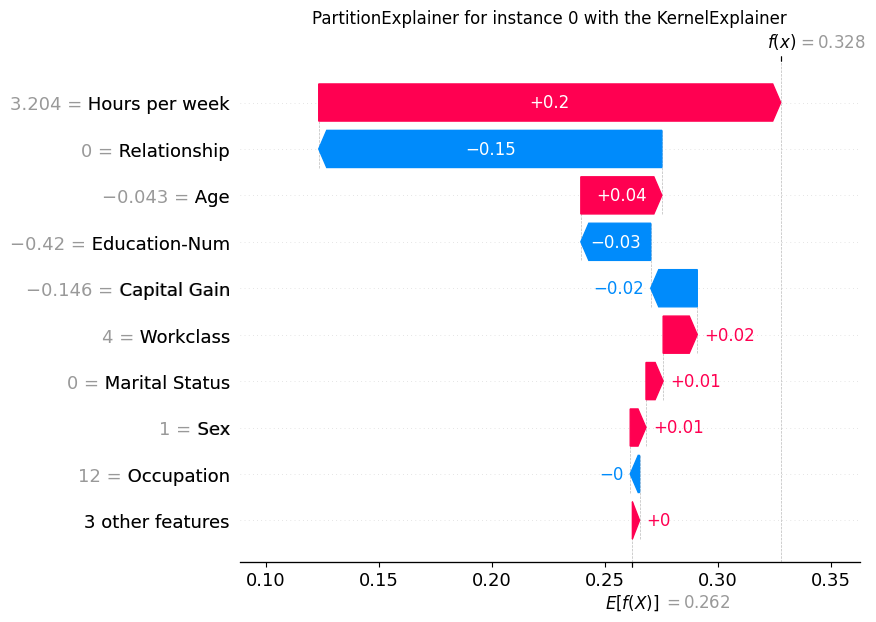

In [15]:
fig, ax = plt.subplots()
shap.plots.waterfall(shap_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the KernelExplainer")
plt.show()

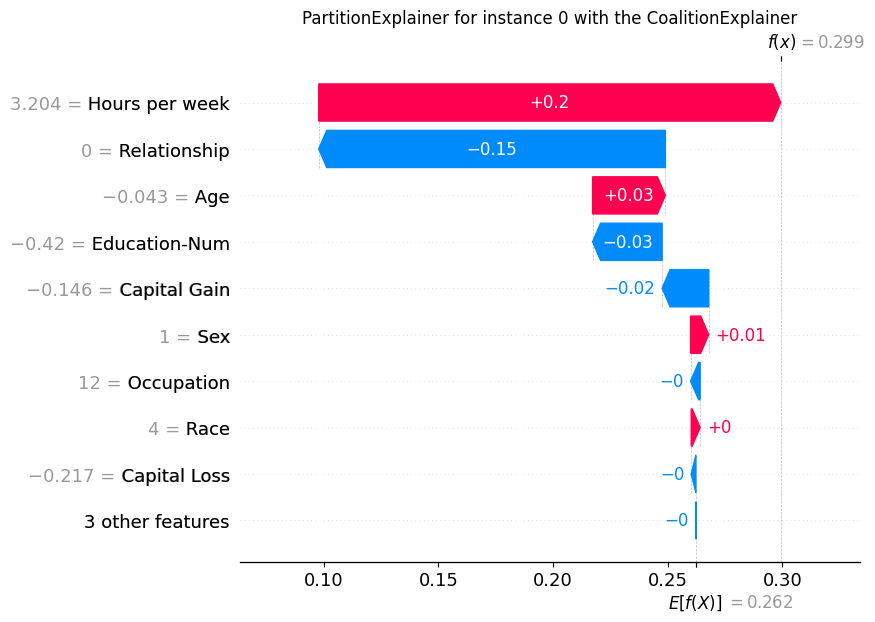

In [16]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the CoalitionExplainer")
plt.show()

In [17]:
shap.initjs()
shap.force_plot(winter_values.base_values, winter_values.values, X_display.iloc[299:300, :])

### Explain many predictions

Here we repeat the above explanation process for 50 individuals. Since we are using a sampling based approximation each explanation can take a couple seconds depending on your machine setup.

In [ ]:
winter_values50 = explainer(X.iloc[320:330, :])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━

In [ ]:
shap_values50 = kernel_explainer.shap_values(X.iloc[320:330, :], nsamples=500)
shap.force_plot(kernel_explainer.expected_value, shap_values50, X_display.iloc[320:330, :])

In [ ]:
shap.force_plot(kernel_explainer.expected_value, shap_values50, X_display.iloc[320:330, :])

In [ ]:
shap.force_plot(winter_values50.base_values, winter_values50.values, X_display.iloc[320:330, :])